# Lab Three: Extending Logistic Regression

#### Machine Learning in Python

Will Lacey - 45906124 - <strong>CSE7324</strong>
<br>
Roger Wong - 43867412 - <strong>CSE5324</strong>

## Preparation and Overview (30 points total)
<em>
    <strong>[20 points]</strong> Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or use mostly for offline analysis? 
</em>

#### Business Understanding

<p>Dataset description: “The data was obtained in a student survey in both Portuguese language and Math courses in secondary school. It contains a lot of interesting social, gender, and study information about students. You can use it for some EDA or try to predict student’s susceptibility to alcohol.” Collected in 2008.</p>
<p>
This dataset has more than 1000 students and 33 features (34 in consideration of which school a student is from) that includes both categorical and numerical data.</p>
<p>
We will be looking at what factors affect student grades. In the dataset are three grades, G1, G2, and G3, which all range from 0-19. In this study, we will take the mean of all the grades and then divide them into three categories. Mean grades less than 10 are classified as 0, which refelect the potential of failing. Mean grades between 10 and 14 are classified as 1, which reflect an equivalent grade to that of a C- or B. And lastly, mean grades between 15 and 19 are classified as 2, which is more or less excelling. Our Multi-Class Logistic Regression will classify the data into those three mean grade classes and determine which students are in need of academic support.
</p>
<p>
Our business case is to see how the factors we chose affects a students overall grade. As our classifier trains with the dataset, it will be able to tell a students overall grade with the given information. The one issue that may arise in the event of rolling out this software to schools is that it is effectively profiling students. However, if schools use the software to help accepted students succeed, this program will be beneficial despite its ethical ramifications. 
</p>
<p>
We believe schools, parents, and colleges will be interested in our business-case because they will be able to better provide support and resources to students, allowing them to achieve the best possible grades. If our classifier has a high enough percentage, then support systems can see which students will struggle the most in the future. We will be able to predict which students need the most help, even if students don't realize what kind of situation they are in.
</p>


#### Measure of Success

<p> Now in order for our classifier to be actually useful to our interested parties, we need to determine an appropriate measure of success. There are two situations we need to pay attention to. One is a false positive where our classifier determines a student will fail but instead they succeed. The second is a false negative where our classifier determines a student will succeed but instead they fail. If our classifier provides too many false positives, then that means extra school resources won't go to students in need. If there are too many false negatives then the failing students will slide under the radar and not get enough extra support. The false negatives take higher priority since the stuggling students won't get the right resources. Alternatively, if passing students get more resources, it isn't the end of the world. Truthfully, the worst case in this scenario is simply that passing students receive attention that could have gone to failing students.
</p>

#### Import Modules and Initialization

Alright. Before we begin, let's import essential packages for data analysis

In [52]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.special import expit
from scipy.optimize import minimize_scalar
from scipy.optimize import fmin_bfgs
import warnings
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore', DeprecationWarning)

%matplotlib inline

<em>
    <strong>[5 points]</strong> (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).
</em>

In [24]:
try:
    df_mat = pd.read_csv('student-mat.csv') # read in the csv file
    df_por = pd.read_csv('student-por.csv') # read in the csv file
    df_mat['class'] = "math"
    df_por['class'] = "portuguese"
    df = pd.concat([df_mat, df_por], ignore_index=True)
    print("Succeeded to Open File.\n")
    print(df.info())

except IOError:
    print("Failed to Open Files. Quitting Program.")
    sys.exit

Succeeded to Open File.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 34 columns):
school        1044 non-null object
sex           1044 non-null object
age           1044 non-null int64
address       1044 non-null object
famsize       1044 non-null object
Pstatus       1044 non-null object
Medu          1044 non-null int64
Fedu          1044 non-null int64
Mjob          1044 non-null object
Fjob          1044 non-null object
reason        1044 non-null object
guardian      1044 non-null object
traveltime    1044 non-null int64
studytime     1044 non-null int64
failures      1044 non-null int64
schoolsup     1044 non-null object
famsup        1044 non-null object
paid          1044 non-null object
activities    1044 non-null object
nursery       1044 non-null object
higher        1044 non-null object
internet      1044 non-null object
romantic      1044 non-null object
famrel        1044 non-null int64
freetime      1044 non-null int64
g

In trying to predict grades, we decided to use our first lab assignment to best select appropriate variables. Any variables that we noticed to have a lack of correlation to grades, we dropped for simplicity. Additionally, we removed information such as absences, so that we could make the assumption that our program would only be used on information prior to the beginning of a semester. This is so a school could aid potentially weaker students before they began to fall behind.

In [3]:
target = df[['G1', 'G2', 'G3']].mean(axis=1)
target[(target < 10)] = 0
target[(target < 15 ) & (target >= 10)] = 1
target[(target >= 15)] = 2
target = target.astype(int)

data = df.drop(
    columns=[
        'school',
        'famsize',
        'Mjob',
        'Fjob',
        'reason',
        'guardian',
        'traveltime',
        'famsup',
        'paid',
        'activities',
        'nursery',
        'internet',
        'romantic',
        'famrel',
        'freetime',
        'goout',
        'health',
        'class',
        'absences',
        'G1',
        'G2',
        'G3'
])

data.head()

,sex,age,address,Pstatus,Medu,Fedu,studytime,failures,schoolsup,higher,Dalc,Walc
0,F,18,U,A,4,4,2,0,yes,yes,1,1
1,F,17,U,T,1,1,2,0,no,yes,1,1
2,F,15,U,T,1,1,2,3,yes,yes,2,3
3,F,15,U,T,4,2,3,0,no,yes,1,1
4,F,16,U,T,3,3,2,0,no,yes,1,2


To better prepare the dataset, we decided to one hot encode and binary encode several variables.

In [4]:
def one_hot_encode(df, feature):
    one_hot = pd.get_dummies(df[feature], prefix = feature)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, one_hot], axis=1)
    return df

def binary_encode(df, feature):
    binary = pd.get_dummies(df[feature], prefix = feature)
    df = df.drop([feature], axis=1)
    df = pd.concat([df, binary.iloc[:,0]], axis=1)
    return df

data = binary_encode(data, 'sex')
data = binary_encode(data, 'Pstatus')
data = binary_encode(data, 'higher')
data = binary_encode(data, 'address')
data = binary_encode(data, 'schoolsup')

data = one_hot_encode(data, 'age')

In [5]:
data.head()

,Medu,Fedu,studytime,failures,Dalc,Walc,sex_F,Pstatus_A,higher_no,address_R,schoolsup_no,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22
0,4,4,2,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0
1,1,1,2,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0
2,1,1,2,3,2,3,1,0,0,0,0,1,0,0,0,0,0,0,0
3,4,2,3,0,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0
4,3,3,2,0,1,2,1,0,0,0,1,0,1,0,0,0,0,0,0


<em>
    <strong>[5 points]</strong> Divide you data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?  
</em>

In [42]:
print('Excelling Student Count:', (target.value_counts())[2])
print('Passing Student Count:', (target.value_counts())[1])
print('Failing Student Count:', (target.value_counts())[0])

Excelling Student Count: 142
Passing Student Count: 581
Failing Student Count: 321


Hmm. This is kind of a problem. Because our classes aren't exactly numerous, it will be hard to train our classifier effectively for each class. Since we are also dividing our classes into an 80/20 split, it will be worrisome that some classes are rarer than others.

In [6]:
num_cv_iterations = 3
num_instances = len(df)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2
)

The following cell demos the cross validation module part of scikit-learn.

In [7]:
split_count = 0
for train_indices, test_indices in cv_object.split(data,target): 
    split_count = split_count + 1
    
    data_train = data.loc[train_indices]
    target_train = target.loc[train_indices]
    
    data_test = data.loc[test_indices]
    target_test = target.loc[test_indices]
    
    print('Split Iteration:', split_count)
    print('-------------------')
    print('training data:', len(data_train))
    print('training target:', len(target_train))
    print('test data:', len(data_test))
    print('test target:', len(target_test))
    print()
    

Split Iteration: 1
-------------------
training data: 835
training target: 835
test data: 209
test target: 209

Split Iteration: 2
-------------------
training data: 835
training target: 835
test data: 209
test target: 209

Split Iteration: 3
-------------------
training data: 835
training target: 835
test data: 209
test target: 209



<p>Most of the time, data scientist split data into 80/20, also known as Pareto's principle. Because our data isn't time sensitive, we believe that an 80/20 split is sufficient for training our classifier. Although, our classes don't exactly follow an equal distribution. On this front, an 80/20 split in our data could prove harmful, since rarer classes may be considered less. On top of this, because we have about 800 instances for the training data and about 200 instances for our testing data, we believe that our training may yield inaccurate results. This is due to the fact that overall, our dataset is lacking a sufficient amount of entries. It would be much nicer if we had 3000 students, 1000 for each grade class, so that we could best find the differences in students and what can be best used to determine grades. Regardless, for the purpose of this lab, we still believe, despite our concerns, that a random 80/20 will be sufficient. </p>

## Modeling (50 points total)
<em>
The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 
<br><br>
<strong>[20 points]</strong> Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
Ability to choose optimization technique when class is instantiated: either steepest descent, stochastic gradient descent, or Newton's method. 
Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.  
</em>
  


In [8]:
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, reg_method='null'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.reg_method = reg_method
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    # vectorized gradient calculation with regularization using specified Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        if (self.reg_method=='L1'):
            gradient[1:] += -1 * self.C * (self.w_[1:]/abs(self.w_[1:])) 
        elif (self.reg_method=='L2'):
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif (self.reg_method=='Both'):
            gradient[1:] += -1 * self.C * (self.w_[1:]/abs(self.w_[1:])) + -2 * self.w_[1:] * self.C
        else:
            gradient[1:] = gradient[1:] 
        return gradient

    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1

    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.ones((num_features,1))
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 


In [9]:
class LineSearchLogisticRegression(BinaryLogisticRegression):
    
    # define custom line search for problem
    @staticmethod
    def line_search_function(eta,X,y,w,grad,C,reg_method):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        if (reg_method=='L1'):
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(abs(wnew)) 
        elif (reg_method=='L2'):
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2)
        elif (reg_method=='Both'):
            return np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(wnew**2) + C*sum(abs(wnew)) 
        else:
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0]))
        
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.ones((num_features,1)) # init weight vector to ones
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.iters/20} # unclear exactly what this should be
            res = minimize_scalar(self.line_search_function, # objective function to optimize
                                  bounds=(self.eta/1000,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C, self.reg_method),
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ += gradient*eta # set new function values

In [10]:
class StochasticLogisticRegression(BinaryLogisticRegression):
    # stochastic gradient calculation 
    def _get_gradient(self,X,y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        if (self.reg_method=='L1'):
            gradient[1:] += -1 * self.C * (self.w_[1:]/abs(self.w_[1:])) 
        elif (self.reg_method=='L2'):
            gradient[1:] += -2 * self.w_[1:] * self.C
        elif (self.reg_method=='Both'):
            gradient[1:] += -1 * self.C * (self.w_[1:]/abs(self.w_[1:])) + -2 * self.w_[1:] * self.C
        else:
            gradient[1:] = gradient[1:] 
            
        return gradient

In [11]:
class BFGSLogisticRegression(BinaryLogisticRegression):

    @staticmethod
    def objective_function(w,X,y,C,reg_method):
        g = expit(X @ w)
        if (reg_method=='L1'):
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(abs(w))  
        elif (reg_method=='L2'):
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2)
        elif (reg_method=='Both'):
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(abs(w)) + C*sum(w**2)  
        else:
            return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0]))
    @staticmethod
    def objective_gradient(w,X,y,C,reg_method):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        if (reg_method=='L1'):
            gradient[1:] += -1 * C * (w[1:]/abs(w[1:])) 
        elif (reg_method=='L2'):
            gradient[1:] += -2 * w[1:] * C
        elif (reg_method=='Both'):
            gradient[1:] += -2 * w[1:] * C + -1 * C * (w[1:]/abs(w[1:])) 
        else:
            gradient[1:] = gradient[1:] 
        return -gradient

    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.ones((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C, self.reg_method), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)

        self.w_ = self.w_.reshape((num_features,1))

In [12]:
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.0001, opt_method='null', reg_method='null'):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.opt_method = opt_method
        self.reg_method = reg_method
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_)
        else:
            return 'Untrained MultiClass Logistic Regression Object'

    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers

        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            if(self.opt_method=='sd'):
                blr = LineSearchLogisticRegression(self.eta,self.iters,self.C,self.reg_method)
            elif(self.opt_method=='sgd'):
                blr = StochasticLogisticRegression(self.eta,self.iters,self.C, self.reg_method)
            elif(self.opt_method=='bfgs'):
                blr = BFGSLogisticRegression(self.eta,self.iters,self.C, self.reg_method)
            else:
                print('Error: Optimization Method Not Found')
                return
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)

        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier

        return np.hstack(probs) # make into single matrix

    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row


Steepest Descent

In [13]:
lr = MultiClassLogisticRegression(0.01,iterations=50, C=0.001, opt_method='sd', reg_method='L1')
lr.fit(data,target)

prediction = lr.predict(data)
print('Accuracy of: ',accuracy_score(target,prediction))

Accuracy of:  0.5565134099616859


Stochastic Gradient Descent

In [14]:
lr = MultiClassLogisticRegression(0.01,iterations=2000,C=0.001, opt_method='sgd', reg_method='L2')
lr.fit(data,target)

prediction = lr.predict(data)
print('Accuracy of: ',accuracy_score(target,prediction))

Accuracy of:  0.6216475095785441


Newton's Method

In [15]:
lr = MultiClassLogisticRegression(_,iterations=50,C=0.001, opt_method='bfgs', reg_method='Both')
lr.fit(data,target)

prediction = lr.predict(data)
print('Accuracy of: ',accuracy_score(target,prediction))

Accuracy of:  0.6408045977011494


<em>
    <strong>[15 points]</strong> Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?
</em>

In [16]:
def plot_gallery(c_values):
    plt.figure(figsize=(14,12))
    count = 0
    for i in range(12):
        count = count + 1
        plt.subplot(3,4,i+1)
        if count == 1 :
            plt.title('None')
            if i == 0:
                plt.ylabel('Steepest Descent')
            elif i == 4:
                plt.ylabel('Stochastic Gradient Descent')
            else: 
                plt.ylabel('Newton\'s Method')
        elif count == 2:
            plt.title('L1')
        elif count == 3:
            plt.title('L2')
        else:
            count = 0
            plt.title('Both')
        graph_c_values(c_values[i])

def graph_c_values(arr):
    plt.plot(arr[:,0],arr[:,1])

def calculate_c_values(eta, iterations, opt_method, reg_method):
    arr = np.array([[-1,-1]])
    step_count = 1000
    for i in range(step_count):
        C = (i / step_count) * 0.4
        lr = MultiClassLogisticRegression(eta,iterations, C, opt_method, reg_method)
        lr.fit(data,target) # reference to global variables
        prediction = lr.predict(data)
        accuracy = accuracy_score(target,prediction)
        arr = np.append(arr, [[C, accuracy]], axis=0)
    return arr[1:] # Removes initialization term

In [17]:
%%time

sns.set(style='darkgrid')

eta = 0.001
iterations = 50
c_values = []
c_values.append(calculate_c_values(eta, iterations, 'sd', 'None'))
c_values.append(calculate_c_values(eta, iterations, 'sd', 'L1'))
c_values.append(calculate_c_values(eta, iterations, 'sd', 'L2'))
c_values.append(calculate_c_values(eta, iterations, 'sd', 'Both'))
c_values.append(calculate_c_values(eta, iterations*20, 'sgd', 'None'))
c_values.append(calculate_c_values(eta, iterations*20, 'sgd', 'L1'))
c_values.append(calculate_c_values(eta, iterations*20, 'sgd', 'L2'))
c_values.append(calculate_c_values(eta, iterations*20, 'sgd', 'Both'))
c_values.append(calculate_c_values(eta, iterations, 'bfgs', 'None'))
c_values.append(calculate_c_values(eta, iterations, 'bfgs', 'L1'))
c_values.append(calculate_c_values(eta, iterations, 'bfgs', 'L2'))
c_values.append(calculate_c_values(eta, iterations, 'bfgs', 'Both'))

CPU times: user 2h 35min 50s, sys: 3min 52s, total: 2h 39min 42s
Wall time: 40min 31s


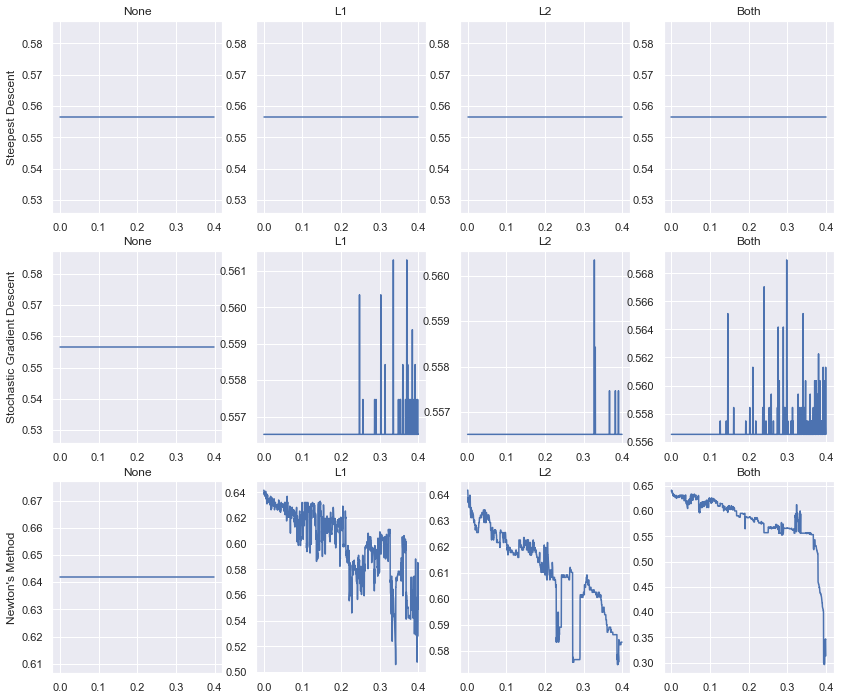

In [18]:
plot_gallery(c_values)

After running each optimization method with each regularization, we determined that Newton's method without a regularization (a C value equal to 0) is most accurate in classification. Undoubtedly, we believe we went through sufficient measures to select the best optimization and regularization method for classification. Additionally, We found that low values of C didn't really effect our steepest descent optimization, but unfortunately, its accuracy never neared that of Newton's method. The X-labels for each graph represents the C values. The Y-labels for each graph represents the accuracy score

In [21]:
num_cv_iterations = 10
num_instances = len(df)
cv_object = ShuffleSplit(
                         n_splits=num_cv_iterations,
                         test_size  = 0.2
)

In [54]:
%%time

split_count = 0
accuracies = np.array([])
for train_indices, test_indices in cv_object.split(data,target): 
    split_count = split_count + 1
    
    data_train = data.loc[train_indices]
    target_train = target.loc[train_indices]
    
    data_test = data.loc[test_indices]
    target_test = target.loc[test_indices]
    
    lr = MultiClassLogisticRegression(_, iterations=1000, C=0, opt_method='bfgs', reg_method='Both')
    lr.fit(data, target) 

    prediction = lr.predict(data_test)
    accuracy = accuracy_score(target_test,prediction)
    accuracies = np.append(accuracies, accuracy)
    
    print('Iteration', split_count,'- Accuracy of:', accuracy)
    print()
    
print('Average Accuracy of our best logistic regression implementation:', np.mean(accuracies))

Iteration 1 - Accuracy of: 0.6220095693779905

Iteration 2 - Accuracy of: 0.6602870813397129

Iteration 3 - Accuracy of: 0.6650717703349283

Iteration 4 - Accuracy of: 0.6650717703349283

Iteration 5 - Accuracy of: 0.645933014354067

Iteration 6 - Accuracy of: 0.5933014354066986

Iteration 7 - Accuracy of: 0.6411483253588517

Iteration 8 - Accuracy of: 0.631578947368421

Iteration 9 - Accuracy of: 0.6076555023923444

Iteration 10 - Accuracy of: 0.6411483253588517

Average Accuracy of our best logistic regression implementation: 0.6373205741626794
CPU times: user 4.33 s, sys: 5.93 s, total: 10.3 s
Wall time: 10.6 s


In ten iterations of shuffling our data into either training or testing and running a logistic regression clasifier, we found our average percentage to be about xx taking a total of yy seconds.

<em>
    <strong>[15 points]</strong> Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 
</em>

In [38]:
%%time

split_count = 0
accuracies = np.array([])
for train_indices, test_indices in cv_object.split(data,target): 
    split_count = split_count + 1
    
    data_train = data.loc[train_indices]
    target_train = target.loc[train_indices]
    
    data_test = data.loc[test_indices]
    target_test = target.loc[test_indices]
    
    lr_sk = LogisticRegression(solver='liblinear') 
    lr_sk.fit(data_train, target_train) 

    prediction = lr_sk.predict(data_test)
    accuracy = accuracy_score(target_test,prediction)
    accuracies = np.append(accuracies, accuracy)
    
    print('Iteration', split_count,'- Accuracy of:', accuracy)
    print()
    
print('Average Accuracy of scikit-learn:', np.mean(accuracies))

Iteration 1 - Accuracy of: 0.5980861244019139

Iteration 2 - Accuracy of: 0.6028708133971292

Iteration 3 - Accuracy of: 0.6411483253588517

Iteration 4 - Accuracy of: 0.6555023923444976

Iteration 5 - Accuracy of: 0.6602870813397129

Iteration 6 - Accuracy of: 0.6555023923444976

Iteration 7 - Accuracy of: 0.6555023923444976

Iteration 8 - Accuracy of: 0.6746411483253588

Iteration 9 - Accuracy of: 0.6985645933014354

Iteration 10 - Accuracy of: 0.6698564593301436

Average Accuracy of scikit-learn: 0.651196172248804
CPU times: user 130 ms, sys: 13.5 ms, total: 143 ms
Wall time: 182 ms


#### Speed Test

In [32]:
%%time
lr = MultiClassLogisticRegression(_, iterations=1000, C=0, opt_method='bfgs', reg_method='Both')
lr.fit(data, target) 

prediction = lr.predict(data)
print('Accuracy of: ',accuracy_score(target,prediction))

Accuracy of:  0.6417624521072797
CPU times: user 624 ms, sys: 903 ms, total: 1.53 s
Wall time: 1.52 s


In [36]:
%%time
lr_sk = LogisticRegression(solver='liblinear') 
lr_sk.fit(data, target) 

prediction = lr_sk.predict(data)
print('Accuracy of: ',accuracy_score(target,prediction))

Accuracy of:  0.6388888888888888
CPU times: user 13.9 ms, sys: 1.62 ms, total: 15.5 ms
Wall time: 19.7 ms


As you can see in the above cells, we made each implementation of logistic regression go through ten iterations of training and testing. Then we took the accuracy mean of each implementation and compared them to each other. We found out our implementation of multi-class logistic regression is a little bit more accurate than scikit-learn's liblinear logistic regression. Yet as you can in our speed test, scikit-learn's implementation is nearly 77 times faster than our implementation.

## Deployment (10 points total)
<em>
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?
</em>

Although our implementation of logistic regression is slightly more accurate than scikit-learn's, our runtime speed is extremely slow. This reduction in speed is largely a result of the number of iteration steps our program has to take as it approaches the optimal weight vector. On the other hand, scikit-learn takes only one step to reach the optimal weight vector while maintaining a high accuracy. As mentioned before, scikit-learn's implementation runs 77 times faster than our own logistic regression. However, in the eyes of a school, speed would actually play less of an importance than accuracy. This is because a school would never really have to run this type of program online, and instead, could run the implementation offline in the beginning of the year for upcoming students. Thus, in selecting our most optimized version of logistic regression, a school would be best prepared to reach out to students most in need of academic support. 

## Exceptional Work (10 points total)
<em>
Implement an optimization technique for logistic regression using mean square error as your objective function (instead of binary entropy). Your solution should be able to solve the binary logistic regression problem in one gradient update step.
</em>

In [43]:
class OptimizedBinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001):
        self.eta = eta
        self.iters = iterations
        self.C = C
        # internally we will store the weights as self.w_ to keep with sklearn conventions

    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term

    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta)
    # vectorized gradient calculation with regularization using L2 Norm
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through

        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += -2 * self.w_[1:] * self.C
        return gradient

    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1

    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction

    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 


We will change the objective function by changing the derivate very partially and then implement it.
When we use mean squared error, our solution should be able to solve binary logistic regression with mean squared error in one gradient step. 
There is a closed form solution for mean squared error for logistic regression so close to something we have already done

In [66]:
class OptimizedBFGSLogisticRegression(OptimizedBinaryLogisticRegression):

    @staticmethod
    def objective_function(w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.log(g[y==1]))-np.sum(np.log(1-g[y==0])) + C*sum(w**2)

    @staticmethod
    def objective_gradient(w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
#         gradient = np.mean(mean_squared_error(X, ydiff[:,np.newaxis])) tried implementing this but it didn't work 
        gradient = gradient.reshape(w.shape)
        gradient[1:] += -2 * w[1:] * C

        return -gradient

    # just overwrite fit function
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape

        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.ones((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)

        self.w_ = self.w_.reshape((num_features,1))

In [67]:
bfgslr = OptimizedBFGSLogisticRegression(_,10,C=0.001)

bfgslr.fit(data, target)
yhat = bfgslr.predict(data)
print('Accuracy of: ',accuracy_score(target,yhat))

Accuracy of:  0.5478927203065134
